In [2]:
import pickle


with open("pair.npy", "rb") as f:
    data = pickle.load(f)

d = set()

for (l, r) in data:
    d.add(l)
    d.add(r)

{'W', 'A', ' ', 'P', 'S', '5', 'Q', 'K', 'D', 'C', 'U', 'Z', 'N', 'R', 'X', 'L', 'O', 'u', 'M', 'T', 'B', 'E'}


In [42]:
num2ch = list(sorted(d))
ch2num = {c: i for i, c in enumerate(list(d))}

In [54]:
import numpy as np

img = np.zeros((len(d), len(d)))

for (l, r) in data:
    img[ch2num[l]][ch2num[r]] += 1


row_sums = img.sum(axis=1)
img = img / row_sums[:, np.newaxis]

/tmp/ipykernel_23882/1382904738.py:10: RuntimeWarning: invalid value encountered in divide
  img = img / row_sums[:, np.newaxis]


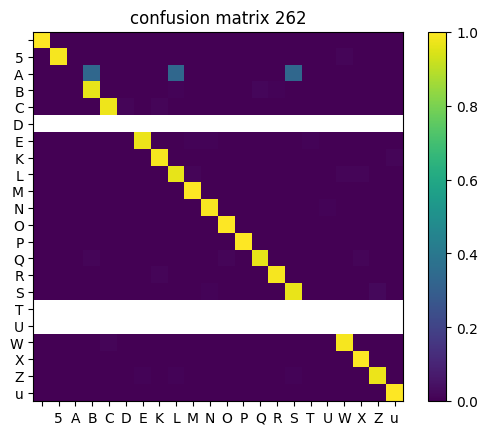

In [57]:
import matplotlib.pyplot as plt

plt.xticks(range(len(d)), num2ch)
plt.yticks(range(len(d)), num2ch)
plt.title(f'confusion matrix {len(data)//6}')
plt.imshow(img)
plt.colorbar()
plt.show()


In [3]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(640, 480)


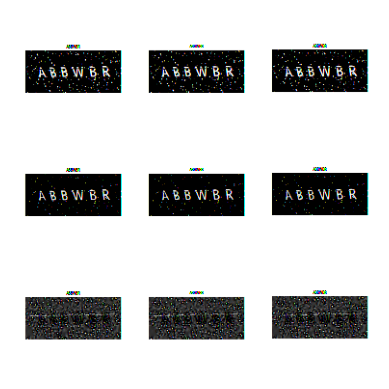

In [61]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

image = Image.open('vis/inter/suc/ABBWBR.png').convert("RGB")
print(image.size)
img = processor(image, return_tensors="pt").pixel_values
img = img.view(384, 384, 3).numpy()

plt.axis('off')
plt.imshow(img)

In [72]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("save/20230324T220333_best")
# model.to(device)




In [80]:
import time

start = time.time()
generated_ids = model.generate(processor(image, return_tensors="pt").pixel_values)
print(time.time() - start)
name = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(name, time.time() - start)

ZC5WX 0.21875309944152832
